# Synthetics and Multi-Table Relational Databases
* This notebook shows how to generate synthetic data directly from a mutli-table relational database
* The database used in the example below was first run through this [notebook](https://github.com/gretelai/public_research/blob/main/mutli-table-transforms/RDB_Transforms.ipynb) which is discussed in this [blog](https://gretel.ai/blog/transforms-and-multi-table-relational-databases) where transforms were used to de-identify PII.


## Capabilities
* This notebook can be run on any database SQLAlchemy supports such as Postgresql, SQLite or MySQL
* This notebook also contains instructions on how to create synthetic data when the relational tables exist in CSV files.
* It is not necessary to first use transforms on your data before using this notebook.
* Referential integriety of primary and foreign keys will remain intact
* User enters the ratio of synthetic records to original records that they would like produced. For example, 2 means you'd like the synthetic data to be twice the size of the original data. Alternatively, you can "subset" the database by using a value less than one. For example, a value of .5 means you'd like the synthetic data to be half the size of the original data.


## Limitations
* The primary and foreign keys in your database must be IDs
* Keys cannot be composite keys
* Cross table field correlations are not maintained.

## How to use this notebook on your own dataset
* Change the database connection string to refer to your database
* Alternatively, change the name and location of the CSV files where your data resides
* Specify the ratio of synthetic to original records you would like produced
* When viewing your data, change the table names used to your own table names
* When viewing the synthetic performance report, change the table name used to one of your own table names
* Modify the location where you'd like your final synthetic data to be stored

## Our ecommerce database
* Execute the below cell to see a diagram of the database we'll be using in this blueprint. The lines in the diagram show connections between primary and foreign keys

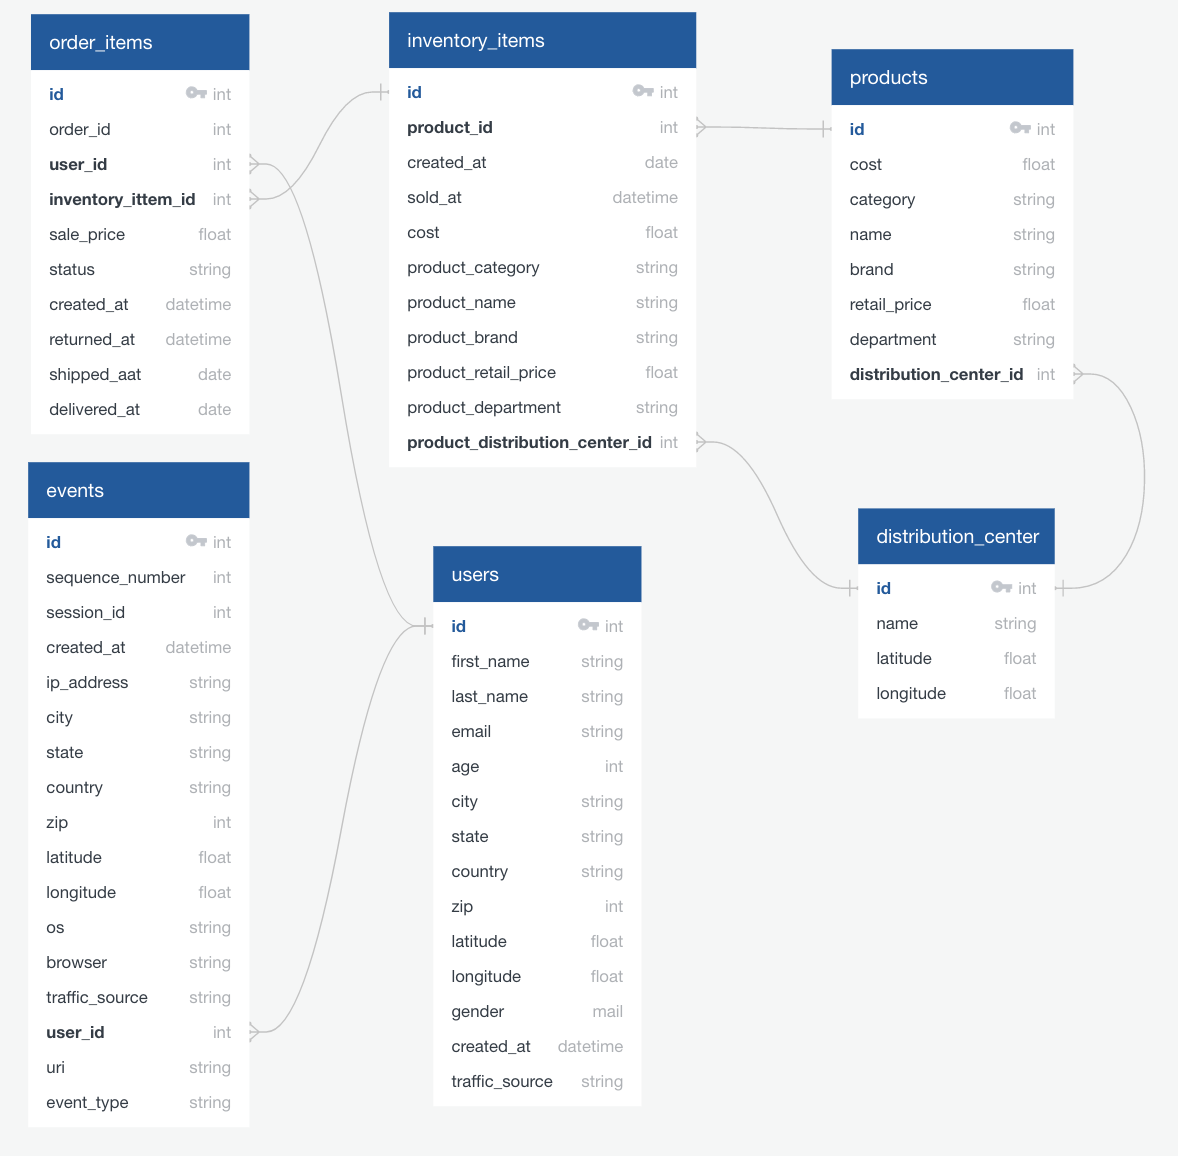

In [1]:
from IPython.display import Image
Image("https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/rdb/ecommerce_db.png",width = 600, height = 600)

## Getting started

In [ ]:
import os

!git clone https://github.com/gretelai/multi-table.git

os.chdir('./multi-table')
!pip install .

In [2]:
# Specify your Gretel API key

from getpass import getpass
import pandas as pd
from gretel_client import configure_session, ClientConfig

pd.set_option('max_colwidth', None)

configure_session(ClientConfig(api_key=getpass(prompt="Enter Gretel API key"), 
                               endpoint="https://api.gretel.cloud"))

Enter Gretel API key········


## Gather data and schema relationships directly from a database
* For demonstration purposes, we'll first grab our ecommerce SQLite database from S3
* This notebook can be run on any database SQLAlchemy supports such as Postgresql or MySQL
* For example, if you have a postgres database, simply swap the `sqlite:///` connection string for a `postgres://` one in the `create_engine` command
* Using SQLAlchemy's reflection extension, we will crawl the schema, gather table data and produce a list of relationships by table primary key.

In [3]:
from sqlalchemy import create_engine
import rdb_util as rdb

!wget https://gretel-blueprints-pub.s3.amazonaws.com/rdb/ecom_xf.db
    
engine = create_engine("sqlite:///ecom_xf.db")
rdb_config = rdb.crawl_db(engine)

--2022-04-16 08:15:48--  https://gretel-blueprints-pub.s3.amazonaws.com/rdb/ecom_xf.db
Resolving gretel-blueprints-pub.s3.amazonaws.com (gretel-blueprints-pub.s3.amazonaws.com)... 52.218.197.139
Connecting to gretel-blueprints-pub.s3.amazonaws.com (gretel-blueprints-pub.s3.amazonaws.com)|52.218.197.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14020608 (13M) [binary/octet-stream]
Saving to: ‘ecom_xf.db.8’

ecom_xf.db.8        100%[===================>]  13.37M  6.32MB/s    in 2.1s    

2022-04-16 08:15:50 (6.32 MB/s) - ‘ecom_xf.db.8’ saved [14020608/14020608]



## Alternatively, specify primary/foreign key relationships and locations of data csv files 
* This is an alternative to the above four cells that work directly with a database
* First, assign `base_path` to the directory where the csv files are located.
* Then, add a name/key pair for each table name/filename to `rdb_config["table_files"]`
* Add all primary keys for each table to `rdb_config["primary_keys"]`
* Add all foreign key/primary keys that connect to the same set under `rdb_config["relationships"]`

In [ ]:
# base_path is the directory where your csv files can be found
base_path = "https://gretel-blueprints-pub.s3.amazonaws.com/rdb/"

rdb_config = {
   "table_files": {
      "users": base_path + "users_transform.csv",

      "order_items": base_path + "order_items_transform.csv",
       
      "events": base_path + "events_transform.csv",
       
      "inventory_items": base_path + "inventory_items_transform.csv",  
       
      "products": base_path + "products_transform.csv",
       
      "distribution_center": base_path + "distribution_center_transform.csv"
   },

  # List the primary keys for each table
    
   "primary_keys": {
      "users": "id",

      "order_items": "id",
       
      "events": "id",
       
      "inventory_items": "id",  
       
      "products": "id",
       
      "distribution_center": "id"
   },

  # List the (table, field) relationships between primary and foreign keys 
    
   "relationships": [
          {("users","id"),
           ("order_items","user_id"),
           ("events","user_id")
          },         
       
          {("inventory_items","id"),
           ("order_items","inventory_item_id")  
          },         

          {("products","id"),
           ("inventory_items","product_id")
          },                

          {("distribution_center","id"),
           ("products","distribution_center_id"),
           ("inventory_items", "product_distribution_center_id")
          }             
   ]
}

# Gather the table data using the filenames entered above

rdb_config["table_data"] = {}
for table in rdb_config["table_files"]:
    filename = rdb_config["table_files"][table]
    df = pd.read_csv(filename)
    rdb_config["table_data"][table] = df

## Enter the ratio of synthetic records to original records you would like to produce

In [4]:
# Entering 1 means the synthetic data will be the same size as the original data
# Entering 2 means the synthetic data will be twice the size as the original data
# Entering .5 means the synthetic data will be half the size of the original data

rdb_config["synth_record_size_ratio"] = 2

## Take a look at your data by joining two tables
* Note that every record in the table "order_items" matches to an entry in the table "users"
* An "inner" join will take the intersection of two tables

In [6]:
pd.set_option("display.max_columns", None)

table1 = "order_items"
table2 = "users"
table1_key = "user_id"
table2_key = "id"
df1 = rdb_config["table_data"][table1]
df2 = rdb_config["table_data"][table2]

joined_data = df1.join(df2.set_index(table2_key), how='inner', on=table1_key, lsuffix='_order_items', rsuffix='_users')
print("Number of records in order_items table is " + str(len(df1)))
print("Number of records in user table is " + str(len(df2)))
print("Number of records in joined data is " + str(len(joined_data)))

joined_data.head()

Number of records in order_items table is 7882
Number of records in user table is 2197
Number of records in joined data is 7882


,id,order_id,user_id,inventory_item_id,sale_price,status,created_at_order_items,returned_at,shipped_at,delivered_at,first_name,last_name,email,age,city,state,country,zip,latitude,longitude,gender,created_at_users,traffic_source
0,272,46660,259,272,8.00,Cancelled,2018-07-25 18:48:01 UTC,None,None,None,Tammy,Jordan,christinamcdowell@haynes.info,53,Sierra Vista,Arizona,USA,85635,41.835673,-100.028364,Male,2017-11-09 12:50:54 UTC,Facebook
1830,3046,152145,259,3046,9.99,Complete,2018-07-27 08:46:52 UTC,None,2018-07-30,2018-08-03,Tammy,Jordan,christinamcdowell@haynes.info,53,Sierra Vista,Arizona,USA,85635,41.835673,-100.028364,Male,2017-11-09 12:50:54 UTC,Facebook
3735,4293,172712,259,4293,64.00,Complete,2018-08-10 15:56:25 UTC,None,2018-08-12,2018-08-15,Tammy,Jordan,christinamcdowell@haynes.info,53,Sierra Vista,Arizona,USA,85635,41.835673,-100.028364,Male,2017-11-09 12:50:54 UTC,Facebook
1,309,71069,290,309,25.00,Cancelled,2017-10-12 20:48:09 UTC,None,None,None,Joseph,Mccoy,mmiller@gutierrez.net,26,Phoenix,Arizona,USA,85061,43.272891,-102.183915,Female,2017-08-18 14:50:56 UTC,Search
1451,5707,245310,290,5707,9.54,Complete,2019-03-24 17:42:03 UTC,None,2019-03-30,2019-04-04,Joseph,Mccoy,mmiller@gutierrez.net,26,Phoenix,Arizona,USA,85061,43.272891,-102.183915,Female,2017-08-18 14:50:56 UTC,Search


## Set up the training configs
* We'll assign each table the default training config
* We'll turn off the similarity privacy filter for the table "distribution_center" as it has only 10 training records
* Similarly, you can modify the other table configs to match the characteristics of that table (see [here](https://github.com/gretelai/gretel-blueprints/tree/main/config_templates/gretel/synthetics) for example configs that can be used).

In [7]:
# Grab the default Synthetic Config file:
from smart_open import open
import yaml
import copy

with open("https://raw.githubusercontent.com/gretelai/gretel-blueprints/main/config_templates/gretel/synthetics/default.yml", 'r') as stream:
    default_config = yaml.safe_load(stream)
    
training_configs = {}
for table in rdb_config["table_data"]:
    training_configs[table] = copy.deepcopy(default_config)

training_configs["distribution_center"]['models'][0]['synthetics']['privacy_filters']['similarity'] = None

## Create synthetic data

In [8]:
import synth_models as sm
from gretel_client import create_project

# Create a new project
project = create_project(display_name="rdb_synthetics")

# Synthesize your tables
synthetic_tables, errors, models = sm.synthesize_tables(rdb_config, project, training_configs)

# Synthesize your primary/foreign keys
if errors == False:
    synthetic_tables = sm.synthesize_keys(synthetic_tables, rdb_config)

Model training started for distribution_center
Model training started for events
Model training started for users
Model training started for inventory_items
Model training started for products
Model training started for order_items
Training completed for distribution_center with SQS score 91 (Excellent)
Generation started for distribution_center
Generation completed for distribution_center
Training completed for users with SQS score 87 (Excellent)
Generation started for users
Training completed for order_items with SQS score 88 (Excellent)
Generation started for order_items
Training completed for inventory_items with SQS score 86 (Excellent)
Generation started for inventory_items
Generation completed for users
Generation completed for order_items
Generation completed for inventory_items
Training completed for events with SQS score 83 (Excellent)
Generation started for events
Training completed for products with SQS score 86 (Excellent)
Generation started for products
Generation complet

## Verify the size of the new synthetic tables

In [9]:
for table in synthetic_tables:
    new_len = len(synthetic_tables[table])
    orig_len = len(rdb_config["table_data"][table])
    ratio = new_len / orig_len
    print("Table " + table + ": Original record count: " + str(orig_len) + " New record count: " + str(new_len) + " Ratio: " + str(ratio))

Table distribution_center: Original record count: 10 New record count: 20 Ratio: 2.0
Table users: Original record count: 2197 New record count: 4394 Ratio: 2.0
Table order_items: Original record count: 7882 New record count: 15764 Ratio: 2.0
Table inventory_items: Original record count: 7882 New record count: 15764 Ratio: 2.0
Table products: Original record count: 29120 New record count: 58240 Ratio: 2.0
Table events: Original record count: 48886 New record count: 97772 Ratio: 2.0


## View the synthetic data
* We'll again join the order_items and users tables

In [10]:
pd.set_option("display.max_columns", None)

table1 = "order_items"
table2 = "users"
table1_key = "user_id"
table2_key = "id"
df1 = synthetic_tables[table1]
df2 = synthetic_tables[table2]

joined_data = df1.join(df2.set_index(table2_key), how='inner', on=table1_key, lsuffix='_order_items', rsuffix='_users')
print("Number of records in order_items table is " + str(len(df1)))
print("Number of records in user table is " + str(len(df2)))
print("Number of records in joined data is " + str(len(joined_data)))

joined_data.head()

Number of records in order_items table is 15764
Number of records in user table is 4394
Number of records in joined data is 15764


,id,order_id,sale_price,status,created_at_order_items,returned_at,shipped_at,delivered_at,user_id,inventory_item_id,first_name,last_name,email,age,city,state,country,zip,latitude,longitude,gender,created_at_users,traffic_source
0,0,71170.0,59.50,Complete,2020-04-04 20:11:19 UTC,NaN,2020-04-08,2020-04-12,2544,13668,Robert,Drake,jwilson@hotmail.com,24,Surprise,Arizona,USA,85379,43.255783,-102.156915,Female,2019-02-25 10:55:40 UTC,Organic
5151,5151,294076.0,24.99,Complete,2021-01-01 08:47:35 UTC,NaN,2021-01-04,2021-01-08,2544,9525,Robert,Drake,jwilson@hotmail.com,24,Surprise,Arizona,USA,85379,43.255783,-102.156915,Female,2019-02-25 10:55:40 UTC,Organic
9539,9539,190977.0,26.99,Complete,2020-07-26 20:51:40 UTC,NaN,2020-07-30,2020-08-04,2544,1773,Robert,Drake,jwilson@hotmail.com,24,Surprise,Arizona,USA,85379,43.255783,-102.156915,Female,2019-02-25 10:55:40 UTC,Organic
14059,14059,153147.0,10.99,Complete,2017-09-12 18:30:55 UTC,NaN,2017-09-22,2017-09-26,2544,14680,Robert,Drake,jwilson@hotmail.com,24,Surprise,Arizona,USA,85379,43.255783,-102.156915,Female,2019-02-25 10:55:40 UTC,Organic
1,1,266279.0,110.00,Cancelled,2019-06-05 09:25:47 UTC,NaN,NaN,NaN,1988,10187,Patricia,Reilly,westseth@parker-brown.com,62,Chandler,Arizona,USA,85246,43.281282,-102.184383,Male,2019-03-13 21:07:40 UTC,Search


## View the synthetic performance reports

In [11]:
# Generate report that shows the statistical performance between the training and synthetic data

from smart_open import open
from IPython.core.display import display, HTML

# Change table_name to any of the tables in your relational database
table_name = "users"
display(HTML(data=open(models[table_name]["model"].get_artifact_link("report")).read(), metadata=dict(isolated=True)))

## Save the synthetic data back into an SQLite database
* Here, we're saving the data into an sqlite database called ecom_synth
* To save into a postgres database, use type="postgres"

In [12]:
# Save the new data to ecom_synth using the schema in ecom_xf
rdb.save_to_rdb("ecom_xf", "ecom_synth", synthetic_tables, engine, type="sqlite")

## Alterntively, save the synthetic content into CSV files

In [ ]:
# Change final_dir to be the location where you'd like your csv files saved
final_dir = "./"
for table in synthetic_tables:
    df = synthetic_tables[table]
    filename = final_dir + table + '_synth.csv'
    df.to_csv(filename, index=False, header=True)